# MLP(Multi Layer Perceptron) - Regression

### Data: Boston_housing

[변수설명]
- medv: 주택가격 <- 레이블(y)
- crim: 1인당 범죄율
- zn: 주거지 비율
- indus: 비주거 상업지역 비율
- chas: 강조망(1-조망, 0-비조망)
- nox: 산회질소 농도
- rm: 평균 방 수
- age: 집의 노후화
- dis: downtown 접근거리
- rad: 방사형 도로 접근성
- tax: 재산세율
- ptratio: 학생/교사 비율
- b: 흑인 인구 비율
- lstat: 저소득층 비율

In [1]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
df_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/BostonHousing.csv")
df_raw.head(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


# 데이터 전처리

In [3]:
x = df_raw.drop(['medv'], axis=1)

y = df_raw['medv']

print(x.shape)
print(y.shape)
print(type(y))

(506, 13)
(506,)
<class 'pandas.core.series.Series'>


In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1234)

print("x_train의 크기: ", x_train.shape)
print("y_train의 크기: ", y_train.shape)

print("x_test의 크기: ", x_test.shape)
print("y_test의 크기: ", y_test.shape)
print(type(y_train))

x_train의 크기:  (354, 13)
y_train의 크기:  (354,)
x_test의 크기:  (152, 13)
y_test의 크기:  (152,)
<class 'pandas.core.series.Series'>


In [19]:
#학습 데이터 Scaling
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scale = scaler.transform(x_train) # x_train_scale은 numpy ndarray 


#테스트 데이터 Scaling
x_test_scale = scaler.transform(x_test) # x_test_scale은 numpy ndarray 


# Array-->Tensor
x_train_tensor = torch.FloatTensor(x_train_scale)
y_train_tensor = torch.FloatTensor(y_train.values) #y_train은 판다스 Series이므로 values를 사용해서 numpy ndarray로 가져오기

x_test_tensor = torch.FloatTensor(x_test_scale)
y_test_tensor = torch.FloatTensor(y_test.values)

In [20]:
train_data = data_utils.TensorDataset(x_train_tensor, y_train_tensor)

dataloader = data_utils.DataLoader(train_data, batch_size=354, shuffle=True, drop_last=True)

for batch_idx, datas in enumerate(dataloader):
  print(batch_idx)
  print(datas[0].shape) # x_train
  print(datas[1].shape) # y_train

0
torch.Size([354, 13])
torch.Size([354])


# Model

In [28]:
# Modeling
class MLP_model(torch.nn.Module):
        def __init__(self, input_size, hidden_size ,output_size):
            super(MLP_model, self).__init__()
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size
            self.hidden2 = 16
            
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden2)
            self.fc3 = torch.nn.Linear(self.hidden2, self.output_size)
            self.relu = torch.nn.ReLU()
            self.sig = torch.nn.Sigmoid()
            
        def forward(self, x):
            fc1 = self.fc1(x)
            ac1 = self.relu(fc1)
            fc2 = self.fc2(ac1)
            ac2 = self.relu(fc2)
            fc3 = self.fc3(ac2)


            return fc3

In [29]:
input_dim = 13
output_dim = 1
hidden_dim = 32
learning_rate = 0.001
n_epochs = 700

In [30]:
model = MLP_model(input_size=input_dim, hidden_size=hidden_dim, output_size=output_dim)

In [31]:
# 손실함수 생성
criterion = torch.nn.MSELoss()

# optimizer 생성
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Training

In [32]:
# Training the model
train_loss = []
test_loss = []

for epoch in range(n_epochs+1):
    
    #Batch 학습
    for idx, (x_batch, y_batch) in enumerate(dataloader):
        optimizer.zero_grad()
        y_pred = model(x_batch)
        y_pred = y_pred.reshape(-1)
        loss_train = criterion(y_pred, y_batch)
        loss_train.backward()
        optimizer.step()
        
        #Validation
        y_test_pred = model(x_test_tensor)
        y_test_pred = y_test_pred.reshape(-1)
        loss_test = criterion(y_test_pred, y_test_tensor)

    train_loss.append(loss_train.item())
    test_loss.append(loss_test.item())
    print("epoch:{}, Loss_train:{:.2f}, Loss_test:{:.2f}".format( epoch, train_loss[-1], test_loss[-1]))

epoch:0, Loss_train:592.93, Loss_test:607.63
epoch:1, Loss_train:589.91, Loss_test:604.62
epoch:2, Loss_train:586.93, Loss_test:601.63
epoch:3, Loss_train:583.96, Loss_test:598.62
epoch:4, Loss_train:580.98, Loss_test:595.57
epoch:5, Loss_train:577.95, Loss_test:592.43
epoch:6, Loss_train:574.85, Loss_test:589.16
epoch:7, Loss_train:571.63, Loss_test:585.74
epoch:8, Loss_train:568.25, Loss_test:582.13
epoch:9, Loss_train:564.69, Loss_test:578.26
epoch:10, Loss_train:560.90, Loss_test:574.12
epoch:11, Loss_train:556.84, Loss_test:569.64
epoch:12, Loss_train:552.44, Loss_test:564.77
epoch:13, Loss_train:547.65, Loss_test:559.43
epoch:14, Loss_train:542.41, Loss_test:553.51
epoch:15, Loss_train:536.62, Loss_test:546.92
epoch:16, Loss_train:530.17, Loss_test:539.48
epoch:17, Loss_train:522.89, Loss_test:531.01
epoch:18, Loss_train:514.61, Loss_test:521.30
epoch:19, Loss_train:505.15, Loss_test:510.10
epoch:20, Loss_train:494.25, Loss_test:497.09
epoch:21, Loss_train:481.61, Loss_test:481.9

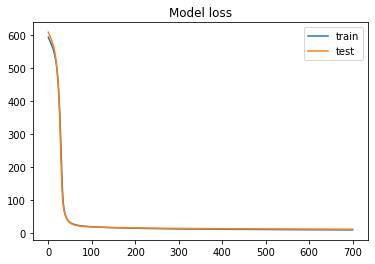

In [33]:
# Loss 값 plot
plt.figure()
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.title('Model loss')
plt.legend(loc='upper right')
plt.show()